# RAG operations in pixeltable

In this tutorial, we'll explore Pixeltable's flexible handling of RAG operations on a collection of PDF documents. In a traditional RAG workflow, such operations might be implemented as a Python script that runs on a periodic schedule or in response to certain events. In Pixeltable, as with everything else, they are implemented as persistent table operations that update incrementally as new data becomes available. 

In [38]:
import pathlib
import pandas as pd
import pixeltable as pxt

Here are some example Q&A pairs for a Q&A rag task

In [67]:
example_data_dir = pathlib.Path('~/Downloads/Documents_Questions/').expanduser()
queries_path = [str(path) for path in example_data_dir.glob('*xlsx')][0]
queries_df = pd.read_excel(queries_path, index_col=0)
queries_df = queries_df.assign(correct_answer=queries_df.correct_answer.map(str))
pxt.drop_table('queries_t', ignore_errors=True, force=True)
queries_t = pxt.create_table('queries_t', schema={'Question': pxt.StringType(), 'correct_answer': pxt.StringType()}, )

queries_t.insert(queries_df.to_dict(orient='records')[:5]) # remove slice to run on all queries.
queries_t.collect()

Created table `queries_t`.
Inserting rows into `queries_t`: 5 rows [00:00, 3836.72 rows/s]
Inserted 5 rows with 0 errors.


Question,correct_answer
What is JPMorgan's net income for the second quarter of 2023 ?,$14.5 Billion
What JPMorgan's net income per share for second quarter of 2023 ?,$4.75 per share
What is the change in JPMorgan debit and credit card sales volume for second quarter of 2023?,The sales volume was up by 7 %
What was the net revenue reported for 2Q23 for JPMorgan Chase?,"$41, 307 Million"
What was the net revenue reported for 2Q23 for JPM?,"$41, 307 Million"


# Outline 

A RAG system comprises two pipelines: preprocessing and querying

1. Preprocessing:
    * Loading documents and splitting them into smaller fragments, or chunks.
    * Using an embedding model, compute a vector embedding for each chunk, Build a vector index over these vectors for low latency lookups at question time.

2. Querying,  for each question Q:
    * From the preprocessed chunks, locate the top-10, or top-k most relevant context chunks for Q, via a top-k vector lookup.
    * Together with the question Q, use the context chunks to construct a large prompt, Use this enriched prompt as a question input to a Large Language Model to generate an answer

Below, we show how to implement both stages with pixeltable.

## 1. Preprocessing

In Pixeltable all data lives in tables, and documents are a type of data.

Tables are persistent containers meant to be the store or record for your data. Since we are starting from scratch, we will start with an empty table `doc_table` with a single column, `document`:

In [40]:
document_paths = [str(path) for path in list(example_data_dir.glob('*.pdf'))]
start_paths = document_paths[:3]
test_paths = document_paths[3:]

In [41]:
import pixeltable as pxt
pxt.drop_table('chunks_t', ignore_errors=True)
pxt.drop_table('chunks2_t', ignore_errors=True)
pxt.drop_table('documents_t', ignore_errors=True)
documents_t = pxt.create_table('documents_t', {'document': pxt.DocumentType()})
documents_t

Created table `documents_t`.


Column Name,Type,Computed With
document,document,


Next, we load a few documents as rows into the table, with an `insert` operation

In [42]:
documents_t.insert([{'document': doc} for doc in start_paths])

Inserting rows into `documents_t`: 3 rows [00:00, 945.23 rows/s]
Inserted 3 rows with 0 errors.


UpdateStatus(num_rows=3, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

document
""
""
""

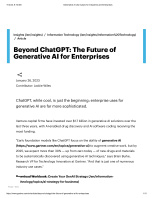
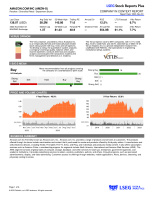
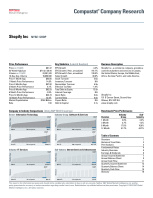

In [43]:
documents_t.show()

In RAG, it is often necessary to decompose long documents into smaller units, or chunks, rather than treating each document as a single entitiy. 
For convenience, Pixeltable offers a `DocumentSplitter` that breaks documents into chunks with multiple user-configurable options controling where to split these chunks

In [44]:
from pixeltable.iterators.document import DocumentSplitter
for i, chunk in enumerate(DocumentSplitter(document_paths[0], separators='paragraph', metadata='page')):
    if i > 5:
        break
    print(chunk)

{'text': '11/4/23, 9:10 AM\nGenerative AI Use Cases for Industries and Enterprises\n', 'page': 0}
{'text': 'https://www.gartner.com/en/articles/beyond-chatgpt-the-future-of-generative-ai-for-enterprises\n1/11\n', 'page': 0}
{'text': 'Insights (/en/insights) /  Information Technology (/en/insights/Information%20Technology)\n', 'page': 0}
{'text': '/  Article\n', 'page': 0}
{'text': 'Beyond ChatGPT: The Future of\nGenerative AI for Enterprises\n', 'page': 0}
{'text': 'ChatGPT, while cool, is just the beginning; enterprise uses for\n', 'page': 0}


In RAG, we compute a vector embedding for each text chunk, and we need to track the correspondence between individual text chunks and their vectors.  Using pixeltable we could create a new table with these chunks and vectors, but when new documents are added or removed from the document table, we would need extra tooling to mark their correspondence and to keep corresponding chunks in sync with their corresponding documents. 

Pixeltable automates these operations through `views`, A `view`, in addition to holding the chunk texts in this case, will stay in sync with the document table: when new documents get added to the document table, the corresponding chunks are added to the view.  

We use `create_view` below to benefit from staying in sync.

In [45]:
pxt.drop_table('chunks_t', ignore_errors=True)
chunks_t = pxt.create_view(f'chunks_t', documents_t, 
                           iterator=DocumentSplitter.create(document=documents_t.document, separators='token_limit', limit=300))
chunks_t

Inserting rows into `chunks_t`: 90 rows [00:00, 13400.81 rows/s]
Created view `chunks_t` with 90 rows, 0 exceptions.


Column Name,Type,Computed With
pos,int,
text,string,
document,document,


There are multiple ways to chunk tables, they can be provided by users, and one can create views from whichever.

In [46]:
# pxt.drop_table('chunks2_t', ignore_errors=True)
# iterator_args = {
#     'document': documents_t.document,
#     'separators': 'paragraph',
#     'metadata': 'page',
# }
# chunks2_t = pxt.create_view(f'chunks2_t', documents_t, iterator_class=DocumentSplitter, iterator_args=iterator_args)
# chunks2_t

`documents_t` behaves much like a table, but already includes data because `doc_table` already holds documents, and all views are kept in sync with their tables.  Also note that the view includes columns from the document splitter, and also a reference `document` to the original document where the chunks came from.



We can select the first 2 chunks from each document using common dataframe operations, in order to get a feel for the chunks extracted:

pos,text,document
0,"11/4/23, 9:10 AM\nGenerative AI Use Cases for Industries and Enterprises\nhttps://www.gartner.com/en/articles/beyond-chatgpt-the-future-of-generative-ai-for-enterprises\n1/11\nInsights (/en/insights) / Information Technology (/en/insights/Information%20Technology)\n/ Article\nBeyond ChatGPT: The Future of\nGenerative AI for Enterprises\nChatGPT, while cool, is just the beginning; enterprise uses for\ngenerative AI are far more sophisticated.\n\nJanuary 26, 2023\nContributor: Jackie Wiles\nVenture capital firms have invested over $1.7 billion in generative AI solutions over the\nlast three years, with AI-enabled drug discovery and AI software coding receiving the\nmost funding. \n""Early foundation models like ChatGPT focus on the ability of generative AI\n(https://www.gartner.com/en/topics/generative-ai) to augment creative work, but by\n2025, we expect more than 30% — up from zero today — of new drugs and materials\nto be systematically discovered using generative AI techniques,"" says Brian Burke,\nResearch VP for Technology Innovation at Gartner. ""And that is just one of numerous\nindustry use cases.""\nDownload Workbook: Create Your GenAI Strategy (/en/information-\ntechnology/topics/ai-strategy-for-business)\nPrivacy - Terms\n11",
1,"/4/23, 9:10 AM\nGenerative AI Use Cases for Industries and Enterprises\nhttps://www.gartner.com/en/articles/beyond-chatgpt-the-future-of-generative-ai-for-enterprises\n2/11\nFive industry use cases for generative AI\nGenerative AI can explore many possible designs of an object to find the right or most\nsuitable match. It not only augments and accelerates design in many fields, it also has\nthe potential to ""invent"" novel designs or objects that humans may have missed\notherwise. \nMarketing and media are already feeling the impacts of generative AI. Gartner\nexpects:\nBy 2025, 30% of outbound marketing messages from large organizations will be\nsynthetically generated, up from less than 2% in 2022. \nBy 2030, a major blockbuster film will be released with 90% of the film generated\nby AI (from text to video), from 0% of such in 2022.\nStill, AI innovations (/en/articles/what-s-new-in-artificial-intelligence-from-the-\n2023-gartner-hype-cycle) are generally accelerating, creating numerous use cases\nfor generative AI in various industries, including the following five.\nNo. 1: Generative AI in drug design\nA 2010 study showed the average cost of taking a drug from discovery to market was\nabout $1.8 billion, of",
0,"Last Close\n138.07 (USD)\n2023 November 02\nNASDAQ Exchange\nAvg Daily Vol\n58.2M\n52-Week High\n145.86\nTrailing PE\n71.6\nAnnual Div\n--\nROE\n12.5%\nLTG Forecast\n--\n1-Mo Return\n6.7%\nMarket Cap\n1.3T\n52-Week Low\n81.43\nForward PE\n48.9\nDividend Yield\n--\nAnnual Rev\n554.0B\nInst Own\n61.1%\n3-Mo Return\n7.7%\nVERUS OPINION\nBuy\nThe Verus Opinion, provided by Verus Analytics Inc,\nis an empirically-derived and historically back-tested\nstock rating system with buy, hold, and sell opinions.\nTo develop a rating, the quantitative system analyzes\na company's earnings quality, balance sheet, and\nincome statement, conducts technical and valuation\nanalysis and evaluates the transactions made by the\nfirm's management and directors (i.e. insiders).\nThe Verus Opinion covers 4591 companies, with 12.1% rated\nBuy, 64.3% rated Hold, and 23.5% rated Sell as of 2023-10-27.\nVerus Analytics Inc is a private independent research firm,\nunaffiliated with Refinitiv, that specializes in engineering\ninstitutional ratings systems.\nI/B/E/S MEAN\nBuy\nMean recommendation from",
1,"all analysts covering\nthe company on a standardized 5-point scale.\n54 Analysts\nStrong\nSell\nSell\nHold\nBuy\nStrong\nBuy\nStrong Buy\nBuy\nHold\nSell\nStrong Sell\n18\n35\n1\n0\n0\nPRICE AND VOLUME CHARTS\n1-Year Return: 49.9%\n5-Year Return: 65.8%\nBUSINESS SUMMARY\nAmazon.com Inc Formerly known as Amazon.com, Inc.. Amazon.com, Inc. provides a range of products and services to cus
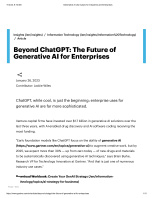
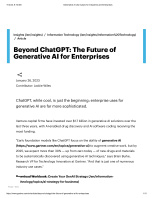
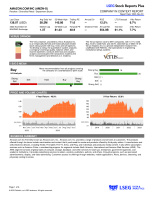
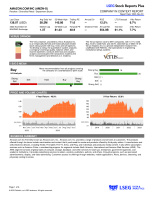
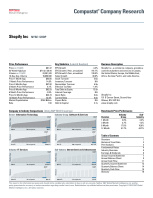
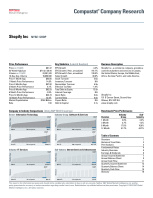

In [47]:
chunks_t.where(chunks_t.pos < 2).show()

### 1.2 Compute vector embeddings and index chunks

In order to offer efficient lookups of relevent chunks, pixeltable offers indexing. Indexing requires an embedding model, in this case we will use pre-trained models from the HuggingFace `sentence_transformers` library. 

To create an embedding index, we specify the input column to the model, a udf to use as an embedding function, and a name for the index (because we often want to have multiple indices built for a single column, which enables us to try may different models). Once embeddings and indices have been created, the preprocessing pipleine is done, and we can move on to the querying component of pixeltable.

*TODO*: note in the writing that vectors, (multiple) indexing artifacts and their relation to chunks is being tracked within pixeltable, I think this is important wrt random workflows.

In [68]:
from embedding import e5_embed, minilm
chunks_t.add_embedding_index(col_name='text', idx_name='e5_index', text_embed=e5_embed)

# 2. Querying

In order to express a top-k similarity lookup for a query, we use the `similarity` operation of the `text` , as well as an `order_by` and `limit` operation on the dataframe, as follows:

In [51]:
query_text = "What is JPMorgan's net income for the second quarter of 2023 ?"
top_5_chunks = (chunks_t.select(chunks_t.text, sim=chunks_t.text.similarity(query_text))
                    .order_by(chunks_t.text.similarity(query_text), asc=False)
                    .limit(5))
top_5_chunks.collect()

text,sim
"Research\nNov. 4, 2023\nCopyright ©2023 S&P Global Market Intelligence Inc. All rights reserved.\n12\nQuarterly Income Statement\nChange vs. Previous Year\nChart of Gross Profit (Loss) \n+ 14.9%\n– 8.5%\n+ 2.7%\n+ 2.4%\n+ 20.0%\n– 9.9%\n+ 14.5%\n600\n800\nMillions of $US\n6/30/23\n3/31/23\n12/31/22\n9/30/22\n6/30/22\n3/31/22\n12/31/21\n9/30/21\nQuarter Ending on\n$1,694\n$1,508\n$1,735\n$1,366\n$1,295\n$1,204\n$1,380\n$1,124\n \nSales/Turnover (Net) \n842\n764\n909\n678\n623\n550\n666\n502\n \nCost of Goods Sold\n852\n744\n826\n688\n672\n654\n714\n622\n \nGross Profit (Loss) \n817\n908\n985\n1,006\n846\n737\n678\n582\n \nSelling, General and Administrative Expenses\n35\n(164)\n(159)\n(318)\n(175)\n(83)\n37\n40\n \nOperating Income Before Depreciation\n18\n29",0.806538
"\n2023-06-30\n0.650\n0.350\n85.7%\nPositive\n2023-04-27\n2023-03-31\n0.310\n0.212\n46.2%\nNegative\n2023-02-02\n2022-12-31\n0.030\n0.175\n-82.9%\nPositive\n2022-10-27\n2022-09-30\n0.280\n0.215\n30.2%\nNegative\n2022-07-28\n2022-06-30\n-0.200\n0.144\n-239%\nSurprise Summary (Last 12 Quarters)\nSurprise Type\nAmount\nPercent\nPositive Quarters (> 2%)\n8\n66.7%\nNegative Quarters (< -2%)\n4\n33.3%\nIn-Line Quarters (within 2%)\n0\n--\nANNUAL REVENUE\nA pattern of increasing sales in\nconjunction with a rising EPS may\ninfluence a buy recommendation, while\nflat or falling sales and faltering\nearnings may explain a sell\nrecommendation. A rising EPS with flat\nor falling sales may result from\nincreased cost efficiency and margins,\nrather than market expansion. This\nchart shows the sales forecast trend of\nall analysts and the highest and lowest\nprojections for the current and next\nfiscal year.\n700B\n650B",0.796639
"\n600B\n550B\n500B\n450B\n2021\n2022\n2023\n2024\nActuals\nEstimates\n469.8B\n514.0B\nMEAN\nHIGH\nLOW\n2023\n2024\nMean\n570.5B\n635.2B\nHigh\n572.2B\n647.1B\nLow\n564.8B\n601.3B\nForecasted Growth\n11.0%\n23.6%\n# of Analysts\n39\n38\nFUNDAMENTAL HIGHLIGHTS\n-\nThe company's gross margin has been higher than its industry\naverage for each of the past five years.\n-\nThe company's days sales in receivables has been higher than its\nindustry average for each of the past five years.\n-\nThe company's interest coverage has been higher than its industry\naverage for each of the past five years.\n-\nAmazon.com Inc does not currently pay a dividend. Of 25 firms within\nthe Department Stores industry, it is among the 18 companies without\na dividend.\nFUNDAMENTAL METRICS\nProfitability\nAMZN\nIndustry\nAvg\nRevenue Growth\n10.3%\n5.1%\nFor year over year\nending 2023-09\nGross Margin\n46.2%\n39.3%\nFor latest 12 months\nending 2023-09\nReturn on Equity\n12.5%\n6.7",0.795032
"+ 18.0%\n+ 657.3%\n+ 501.8%\n+ 18.7%\nNot Meaningful\n0\n250\n500\nMillions of $US\n2022\n2021\n2020\n2019\n2018\n2017\n2016\n2015\nOPERATING ACTIVITIES\n($3,460)\n$2,915\n$320\n($125)\n($65)\n($40)\n($35)\n($19)\n \nIncome Before Extraordinary Items\n93\n69\n79\n36\n27\n23\n14\n7\n \nDepreciation and Amortization\n(187)\n191\n(42)\n(38)\n0\n0\n0\n0\n \nDeferred Taxes\n3,516\n(2,509)\n169\n178\n103\n50\n22\n10\n \nFunds from Operations - Other excluding Option Tax Benefit\n3,516\n(2,509)\n169\n178\n103\n50\n22\n10\n \nFunds from Operations - Other\n(128)\n(338)\n(142)\n(130)\n(83)\n(51)\n(14)\n1\n \nAccounts Receivable - Decrease (Increase) \n37\n138\n119\n85\n21\n15\n20\n11\n \nAccounts Payable and Accrued Liabilities - Increase (Decrease) \nCF\nCF\nCF\nCF\n0\n0\n0\n0\n \nIncome Taxes - Accrued - Increase",0.793551
"\n23-12\n24-03\nActuals\nEstimates\n0.030\n0.310\n0.650\n0.940\nMEAN\nHIGH\nLOW\nQuarterly\n23-12\n24-03\nMean\n0.767\n0.674\nHigh\n1.000\n1.040\nLow\n0.570\n0.360\n# of Analysts\n33\n19\n8.000\n6.000\n4.000\n2.000\n0.000\n-2.000\n2021\n2022\n2023\n2024\nActuals\nEstimates\n3.241\n-0.270\nMEAN\nHIGH\nLOW\nAnnual\n2023\n2024\nMean\n2.664\n3.510\nHigh\n2.900\n4.580\nLow\n2.470\n2.330\n# of Analysts\n39\n39\nAMAZON.COM INC (AMZN-O)\nRetailers / Diversified Retail /

Generally we want to evaluate RAG over multiple queries, not just one.
One option is looping over all queries doing a pixeltable query for each one, like we did for top_k_matches.
However, when we extend the set of test queries we would like to evaluate an answer without extra plumbing.
Instead, we can crate a `queries` table that holds queries, and define a column to hold each queries' top-k context
chunks.

Pixeltable UDF let us express an always-up-to-date looping pattern over this queries table as follows


Now, we can define a new computed column on the queries table:


In [72]:
@pxt.query
def top_k_chunks(chunks_table: pxt.Table, query_text: str) -> pxt.DataFrame:
    """ note the first argument is a table, the rest are the query arguments,
    the return type is a DataFrame """
    t = chunks_table
    return (t.select(t.text, sim=t.text.similarity(query_text))
            .order_by(t.text.similarity(query_text), asc=False)
            .limit(5))

In [73]:
queries_t.add_column(question_context=chunks_t.query(top_k_chunks)(queries_t.Question))

Computing cells: 100%|████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04 cells/s]
Added 5 column values with 0 errors.


UpdateStatus(num_rows=5, num_computed_values=5, num_excs=0, updated_cols=[], cols_with_excs=[])

Now we can pass this context along with a prompt to LLMs such as open ai, defining both the prompts and the model outputs as more columns in the dataframe

In [74]:
queries_t.select(queries_t.Question, queries_t.question_context).collect()

Question  \
0  What is JPMorgan's net income for the second q...   
1  What JPMorgan's net income per share for secon...   
2  What is the change in JPMorgan debit and credi...   
3  What was the net revenue reported for 2Q23 for...   
4  What was the net revenue reported for 2Q23 for...   

                                    question_context  
0  [{'sim': 0.8931884372104801, 'text': 'JPMORGAN...  
1  [{'sim': 0.895804729932688, 'text': 'JPMORGAN ...  
2  [{'sim': 0.8703465721114452, 'text': 'JPMORGAN...  
3  [{'sim': 0.8751954771520091, 'text': 'JPMORGAN...  
4  [{'sim': 0.8567404236352206, 'text': 'ase.com ...

In [76]:
@pxt.udf
def concat_context(context_list: list[dict]) -> str:
    return ' '.join(elt['text'] for elt in context_list)

In [79]:
queries_t.add_column(context=concat_context(queries_t.question_context))

Computing cells: 100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 368.24 cells/s]
Added 5 column values with 0 errors.


UpdateStatus(num_rows=5, num_computed_values=5, num_excs=0, updated_cols=[], cols_with_excs=[])

In [81]:
messages = [
    { "role": "system", "content": "Please read the following passages and answer the questions that follow based on them" },
    { "role": "user", "content":  queries_t.context},
    { "role": "user", "content":  queries_t.Question},
]
queries_t.add_column(messages=messages)

Computing cells: 100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 322.75 cells/s]
Added 5 column values with 0 errors.


UpdateStatus(num_rows=5, num_computed_values=5, num_excs=0, updated_cols=[], cols_with_excs=[])

Now we can call our model of choice as a pixeltable UDF, following API

In [82]:
from pixeltable.functions import together
queries_t.add_column(response=together.chat_completions(model="meta-llama/Llama-3-8b-chat-hf", messages=queries_t.messages))

Computing cells: 100%|████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/ cells]
Added 5 column values with 0 errors.


UpdateStatus(num_rows=5, num_computed_values=5, num_excs=0, updated_cols=[], cols_with_excs=[])

In [83]:
queries_t.add_column(answer=queries_t.response.choices[0].message.content)

Computing cells: 100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 371.27 cells/s]
Added 5 column values with 0 errors.


UpdateStatus(num_rows=5, num_computed_values=5, num_excs=0, updated_cols=[], cols_with_excs=[])

In [84]:
queries_t.select(queries_t.Question, queries_t.answer, queries_t.correct_answer).collect()

Question,answer,correct_answer
What was the net revenue reported for 2Q23 for JPM?,"According to the passage, the net revenue reported for 2Q23 for JPM is $41.3 billion.","$41, 307 Million"
What is JPMorgan's net income for the second quarter of 2023 ?,"According to the passage, JPMorgan Chase's net income for the second quarter of 2023 is $14.5 billion ($4.75 per share).",$14.5 Billion
What JPMorgan's net income per share for second quarter of 2023 ?,"According to the passage, JPMorgan's net income per share for the second quarter of 2023 is $4.75 per share, excluding significant items, and $4.37 per share, including significant items.",$4.75 per share
What is the change in JPMorgan debit and credit card sales volume for second quarter of 2023?,"According to the passage, the change in JPMorgan debit and credit card sales volume for the second quarter of 2023 is up 7%.",The sales volume was up by 7 %
What was the net revenue reported for 2Q23 for JPMorgan Chase?,"According to the passage, the net revenue reported for 2Q23 for JPMorgan Chase was $41.3 billion.","$41, 307 Million"


### Last step: Add new documents, and see updates propagate

In [63]:
documents_t.insert({'document':p} for p in test_paths)

Inserting rows into `documents_t`: 4 rows [00:00, 3549.23 rows/s]
Inserting rows into `chunks_t`: 267 rows [00:00, 523.89 rows/s]
Inserted 271 rows with 0 errors.


UpdateStatus(num_rows=271, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

document
""
""
""
""
""
""
""

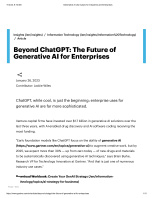
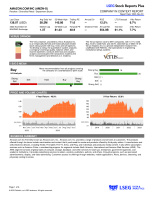
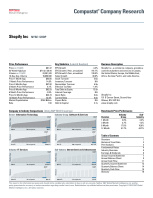
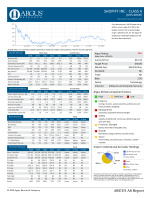
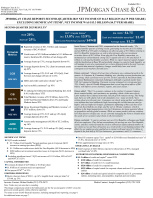
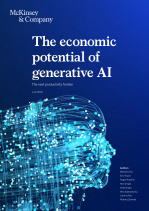
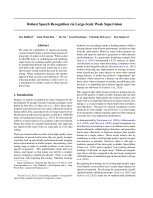

In [64]:
documents_t.collect()

text,document
"11/4/23, 9:10 AM\nGenerative AI Use Cases for Industries and Enterprises\nhttps://www.gartner.com/en/articles/beyond-chatgpt-the-future-of-generative-ai-for-enterprises\n1/11\nInsights (/en/insights) / Information Technology (/en/insights/Information%20Technology)\n/ Article\nBeyond ChatGPT: The Future of\nGenerative AI for Enterprises\nChatGPT, while cool, is just the beginning; enterprise uses for\ngenerative AI are far more sophisticated.\n\nJanuary 26, 2023\nContributor: Jackie Wiles\nVenture capital firms have invested over $1.7 billion in generative AI solutions over the\nlast three years, with AI-enabled drug discovery and AI software coding receiving the\nmost funding. \n""Early foundation models like ChatGPT focus on the ability of generative AI\n(https://www.gartner.com/en/topics/generative-ai) to augment creative work, but by\n2025, we expect more than 30% — up from zero today — of new drugs and materials\nto be systematically discovered using generative AI techniques,"" says Brian Burke,\nResearch VP for Technology Innovation at Gartner. ""And that is just one of numerous\nindustry use cases.""\nDownload Workbook: Create Your GenAI Strategy (/en/information-\ntechnology/topics/ai-strategy-for-business)\nPrivacy - Terms\n11",
"Last Close\n138.07 (USD)\n2023 November 02\nNASDAQ Exchange\nAvg Daily Vol\n58.2M\n52-Week High\n145.86\nTrailing PE\n71.6\nAnnual Div\n--\nROE\n12.5%\nLTG Forecast\n--\n1-Mo Return\n6.7%\nMarket Cap\n1.3T\n52-Week Low\n81.43\nForward PE\n48.9\nDividend Yield\n--\nAnnual Rev\n554.0B\nInst Own\n61.1%\n3-Mo Return\n7.7%\nVERUS OPINION\nBuy\nThe Verus Opinion, provided by Verus Analytics Inc,\nis an empirically-derived and historically back-tested\nstock rating system with buy, hold, and sell opinions.\nTo develop a rating, the quantitative system analyzes\na company's earnings quality, balance sheet, and\nincome statement, conducts technical and valuation\nanalysis and evaluates the transactions made by the\nfirm's management and directors (i.e. insiders).\nThe Verus Opinion covers 4591 companies, with 12.1% rated\nBuy, 64.3% rated Hold, and 23.5% rated Sell as of 2023-10-27.\nVerus Analytics Inc is a private independent research firm,\nunaffiliated with Refinitiv, that specializes in engineering\ninstitutional ratings systems.\nI/B/E/S MEAN\nBuy\nMean recommendation from",
"Shopify Inc\nNYSE: SHOP\nPrice Performance\non 11/3/23\n$61.47\nPrice\n$71.43 / 30.44\n52-Week High/Low\non 11/3/23\n22,381,243\nVolume\n16,696,930\n10-Day Avg. Volume\n$53.65\nPrice 1 Month Ago\n14.6%\n1 Month Price Performance\n$57.93\nPrice 3 Months Ago\n6.1%\n3 Month Price Performance\n$62.03\nPrice 6 Months Ago\n-0.9%\n6 Month Price Performance\n$33.74\nPrice 12 Months Ago\n82.2%\n12 Month Price Performance\n$78.8 Billion\nMarket Capitalization\n1.93\nBeta\nKey Statistics (Latest 4 Quarters)\n-4.3%\nEPS Growth\n191.7%\nEPS Growth 3 Year, annualized\n130.5%\nEPS Growth 5 Year, annualized\n30.8%\nSales Growth\n0.6x\nAsset Turnover\nNA\nInventory Turnover\n6.9x\nReceivables Turnover\n-1.4%\nEffective Tax Rate\n15.9x\nTotal Debt to Equity\nNA\nInterest Coverage\n6.6x\nQuick Ratio\n6.8x\nCurrent Ratio\nNA\nPayout Ratio\n0.1x\nDebt to Capital",
"®\nSHOPIFY INC - CLASS A\n(NYS:SHOP)\nReport Date: November 01, 2023\nOver the past year, SHOP shares are up\n44.6%, versus a gain of 13.9% for the\nbroader market. The 52 week trading\nrange is $30.44 to $71.43. The Argus A6\ntarget price is $38 representing a 19.5%\nloss from the current level.\nShopify offers an e-commerce platform primarily to small and medium-size businesses. The firm has two segments.\nH\nL\nL\nM\nL\nM\nArgus Rating:\nRating Since: 10/25/23\nSELL\nCurrent Price:\n$47.19\nTarget Price:\n$38.00\nMarket Cap:\n$56.8 billion\nDividend:\nNil\nYield:\nNil\nBeta:\n2.56\nSector:\nTechnology\nIndustry:\nSoftware and Computer Services\nArgus A6 Sub-component Scores\nH\nHigh\nM\nMedium\nL\nLow\nIndustry\nEarnings revisions, analyst conviction, performance an
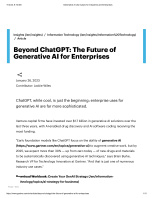
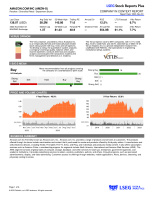
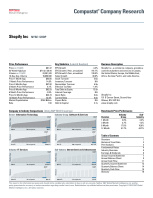
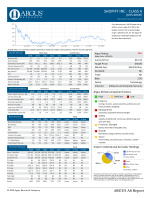
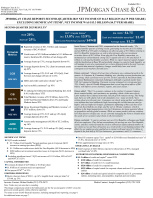
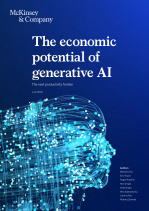
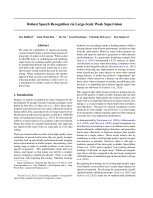

In [65]:
chunks_t.select(chunks_t.text, chunks_t.document).where(chunks_t.pos < 1).collect()

In [66]:
queries_t.select(queries_t.Question, queries_t.correct_answer, queries_t.answer).limit(2).collect()

Question,correct_answer,answer
What is JPMorgan's net income for the second quarter of 2023 ?,$14.5 Billion,"There is no information about JPMorgan's net income in the provided passages. The passages appear to be about Amazon.com Inc (AMZN-O), a retailer, and do not mention JPMorgan."
What JPMorgan's net income per share for second quarter of 2023 ?,$4.75 per share,The passage does not mention JPMorgan's net income per share for the second quarter of 2023. The passage appears to be about Amazon.com Inc (AMZN-O) and provides financial information and analyst estimates for the company.
